In [9]:
import nltk
from nltk.tokenize import word_tokenize
import unicodedata
import pandas as pd
from bs4 import BeautifulSoup


import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

def remove_acentos(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

stopwords = set(nltk.corpus.stopwords.words('english'))

def clean_html(text):
    # Usando BeautifulSoup para limpar o HTML
    soup = BeautifulSoup(text, "html.parser")
    clean_text = soup.get_text()  # Extrai o texto limpo
    return clean_text

def normalize_text(txt):
    txt = clean_html(txt)
    
    return ' '.join(
        [
            word for word in word_tokenize(remove_acentos(txt).lower())
            if word not in stopwords and word.isalpha()
        ]
    )

df = pd.read_json('filtered_dataset/selected_producties.json', lines=True)
df = df.explode('description')
df['NORMALIZED_DESCRIPTION'] = df.apply(lambda line: normalize_text(str(line['description'])), axis=1)

df = df.groupby("asin", as_index=False).agg({"title": "first", "category": 'first', "description": " ".join, 'NORMALIZED_DESCRIPTION': " ".join, "feature": 'first', "rank": "first", "brand": "first"}).reset_index()

df

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/antonio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/antonio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/antonio/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,index,asin,title,category,description,NORMALIZED_DESCRIPTION,feature,rank,brand
0,0,0005119367,Joseph VHS,"[Studio Specials, Warner Home Video, All Titles]","Ben Kingsley(star of 1993's Best Picture, Stev...",ben kingsley star best picture steven spielber...,[],401614.0,Ben Kingsley
1,1,0005123968,Cedarmont Kids: Action Bible Songs - 17 Classi...,"[Christian Video, Bible]",Cedarmont Kids: Action Bible Songs - 17 Classi...,cedarmont kids action bible songs classic chri...,[],139486.0,
2,2,0006486576,Jesus VHS,"[Christian Video, General]",This classic film portrays 3 years of Jesus' m...,classic film portrays years jesus ministry tol...,[],379753.0,Brian Deacon
3,3,0307142477,Frosty Returns VHS,"[Science Fiction & Fantasy, Science Fiction, A...",In the same way that many a Hollywood sequel h...,way many hollywood sequel little first film fr...,[],309940.0,Jonathan Winters
4,4,0307142493,Santa Claus Is Comin' To Town VHS,"[Science Fiction & Fantasy, Science Fiction, A...",This is The VHS Movie: SANTA CLAUS IS COMIN TO...,vhs movie santa claus comin town original clas...,[],347709.0,Fred Astaire
...,...,...,...,...,...,...,...,...,...
11345,11345,B0009RQSFK,ECW: One Night Stand,[Sports],Studio: Genius Products Inc Release Date: 06/...,studio genius products inc release date,[],54499.0,Paul Heyman
11346,11346,B0009RQSSW,Fraggle Rock - Complete First Season,"[Studio Specials, Universal Studios Home Enter...",The adventures of a group of furry creatures c...,adventures group furry creatures called fraggl...,[],134784.0,Karen Prell
11347,11347,B0009S2K9W,Marilyn Monroe - The Final Days,[Documentary],Over 40 years after Marilyn Monroe's death hal...,years marilyn monroe death halted production c...,[],159839.0,James Coburn
11348,11348,B0009S2SP8,As Time Goes By - Complete Series 8 &amp; 9,"[Studio Specials, Warner Home Video, Drama]",<![CDATA[ As Time Goes By: Complete Series 8 &...,time goes complete series dbl dvd upon time d...,[],41999.0,Various


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf(docs):
    vectorizer = TfidfVectorizer(
        lowercase=True,
        ngram_range=(1,2),
        min_df=2,
        max_df=0.9,
        sublinear_tf=True,
        smooth_idf=True
    )
    tfidf = vectorizer.fit_transform(docs)
    return tfidf, vectorizer

docs = df['NORMALIZED_DESCRIPTION'].tolist()

tfidf, vectorizer = get_tfidf(docs)

In [11]:
import numpy as np

words = vectorizer.get_feature_names_out()

tfidf_sum = np.array(tfidf.sum(axis=0)).flatten()

word_freq = pd.DataFrame(list(zip(words, tfidf_sum)), columns=["Word", "TF-IDF Sum"])

word_freq = word_freq.sort_values(by="TF-IDF Sum", ascending=False)

print(word_freq.head(50))

            Word  TF-IDF Sum
97377        vhs  439.294684
90105       tape  174.225908
97422   vhs tape  162.391917
32406       film  122.851903
62585        new  119.849279
25381        dvd  119.076700
64610        one  114.860446
60397      movie  100.946995
87160      story   87.683063
24706      drama   86.917572
52056       life   86.751601
16407     comedy   86.643843
101787     world   78.284292
92132       time   77.897891
95074        two   76.081044
54283       love   73.683159
55859        man   71.724106
103077     young   70.294857
33864      first   70.069043
38872       good   68.446001
80413     series   67.295883
30574     family   65.315256
52545       like   64.526614
15159    classic   64.198152
97530      video   62.998854
23172   director   62.208451
8036        best   60.745012
80848        set   59.916489
39473      great   57.818510
2385        also   56.246286
591       action   55.911723
65618   original   54.337380
98714        war   52.100945
5869        ba

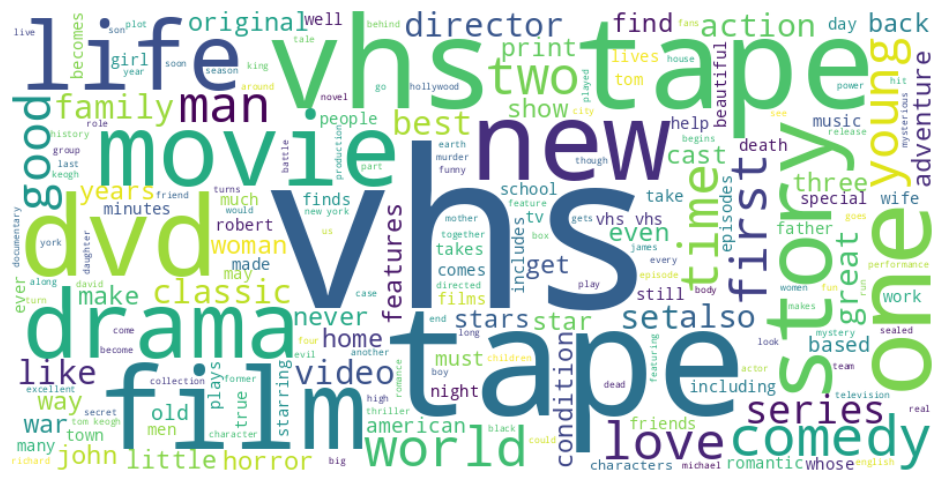

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

soma_tfidf = np.asarray(tfidf.sum(axis=0)).ravel()
termos = vectorizer.get_feature_names_out()
frequencias = dict(zip(termos, soma_tfidf))

wc = WordCloud(
    width=800, height=400,
    background_color="white",
    max_words=200
).generate_from_frequencies(frequencias)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [13]:
df["description"].str.len().median()

805.5

In [14]:
import gensim.corpora as corpora
import gensim.models
import gensim
import re
import spacy

def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

data_words = list(sent_to_words(docs))

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stopwords, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm',Q disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

id2word = corpora.Dictionary(data_ready)

corpus = [id2word.doc2bow(text) for text in data_ready]

lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=9, 
    random_state=100,
    update_every=1,
    chunksize=500,
    passes=10,
    alpha='asymmetric',
    iterations=200,
    per_word_topics=True
)
    

<>:9: SyntaxWarning: invalid escape sequence '\S'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\S'
<>:10: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_49602/1450297238.py:9: SyntaxWarning: invalid escape sequence '\S'
  sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
/tmp/ipykernel_49602/1450297238.py:10: SyntaxWarning: invalid escape sequence '\s'
  sent = re.sub('\s+', ' ', sent)  # remove newline chars


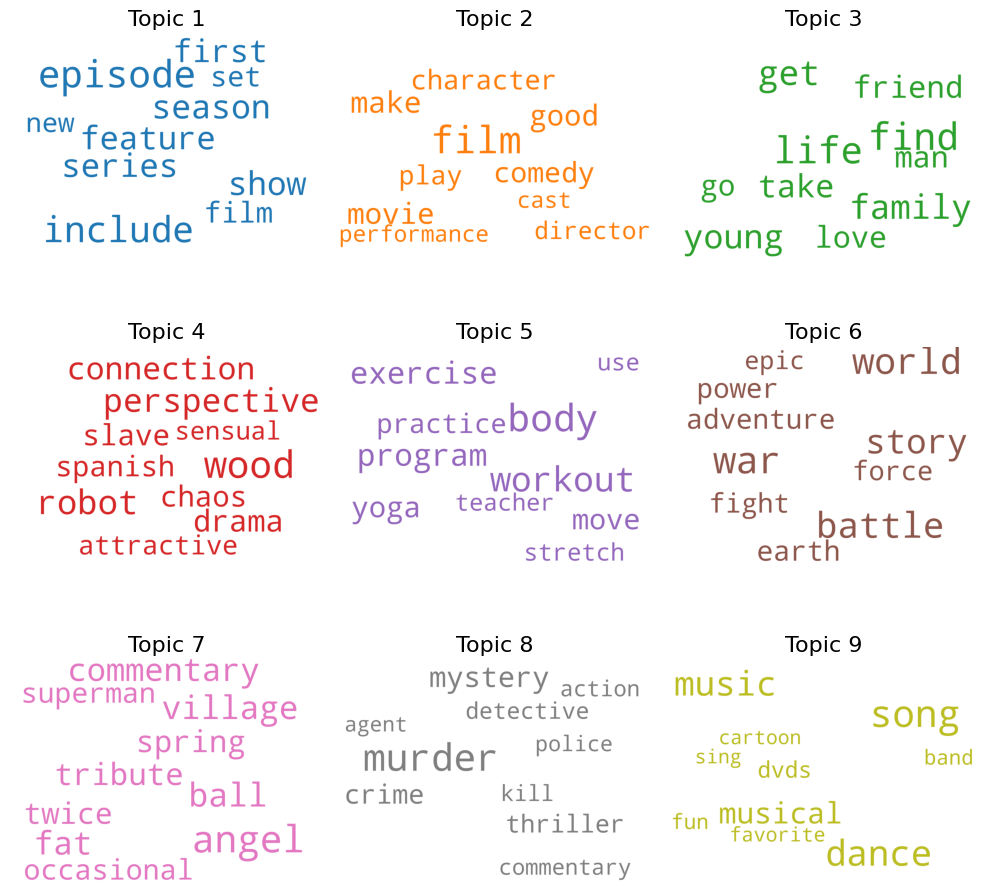

In [15]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] 

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i < len(topics):  
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        ax.imshow(cloud)
        ax.set_title(f'Topic {i+1}', fontdict=dict(size=16)) 
        ax.axis('off')  


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [16]:
topics

[(0,
  [('episode', 0.016222565),
   ('include', 0.014868965),
   ('season', 0.012501075),
   ('show', 0.012123089),
   ('series', 0.012044564),
   ('feature', 0.0118899355),
   ('first', 0.011356173),
   ('film', 0.009352188),
   ('set', 0.009090306),
   ('new', 0.008209256)]),
 (1,
  [('film', 0.019480499),
   ('make', 0.011151732),
   ('movie', 0.010806337),
   ('good', 0.0105790105),
   ('comedy', 0.010009838),
   ('character', 0.009338673),
   ('play', 0.008900412),
   ('director', 0.007449655),
   ('performance', 0.006441001),
   ('cast', 0.0064260582)]),
 (2,
  [('find', 0.012797879),
   ('life', 0.0124792885),
   ('get', 0.010739233),
   ('family', 0.01033675),
   ('young', 0.010021027),
   ('take', 0.009114642),
   ('friend', 0.008391333),
   ('love', 0.008107704),
   ('man', 0.00806674),
   ('go', 0.007635757)]),
 (3,
  [('wood', 0.016942857),
   ('robot', 0.013579714),
   ('perspective', 0.012723752),
   ('connection', 0.011642615),
   ('drama', 0.010837861),
   ('slave', 0.